In [1]:
import pymssql
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import datetime as dt
import warnings
import dateutil.relativedelta
from sklearn.model_selection import train_test_split as train
from mlxtend.evaluate import lift_score
from sklearn.metrics import make_scorer, roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgbm 
from sklearn import ensemble
import uncertainties
import random
from random import randint
import seaborn as sns
from uncertainties import ufloat
from sklearn.metrics import precision_recall_curve, classification_report
from dateutil.relativedelta import relativedelta
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

# Данные

In [2]:
df = pd.read_hdf('/mnt/cda/week_churn_kat_1802.hdf', "df")

In [3]:
print ("Кол-во уникальных клиентов", df['mems_id'].nunique())
print ()
print ("Кол-во дат за весь период", df['Datum'].nunique())
print ()
print ("Первая дата", df['Datum'].min())
print ()
print ("Последняя дата", df['Datum'].max())

Кол-во уникальных клиентов 2027802

Кол-во дат за весь период 61

Первая дата 2018-06-03 00:00:00

Последняя дата 2019-07-28 00:00:00


### train test for GS

In [4]:
train_cv = df[(df['Fold_1'] == 'train') | (df['Fold_2'] == 'train') |\
              (df['Fold_1'] == 'test') | (df['Fold_2'] == 'test')|\
             (df['Fold_3'] == 'train') | (df['Fold_3'] == 'test')].sample(1000000).reset_index()

In [5]:
train_ind_1 = train_cv[train_cv['Fold_1'] == 'train'].index.values.astype(int)
test_ind_1 = train_cv[train_cv['Fold_1'] == 'test'].index.values.astype(int)
train_ind_2 = train_cv[train_cv['Fold_2'] == 'train'].index.values.astype(int)
test_ind_2 = train_cv[train_cv['Fold_2'] == 'test'].index.values.astype(int)
train_ind_3 = train_cv[train_cv['Fold_3'] == 'train'].index.values.astype(int)
test_ind_3 = train_cv[train_cv['Fold_3'] == 'test'].index.values.astype(int)

In [7]:
y_train_cv = train_cv['Churn']
X_train_cv = train_cv.drop(['index', 'Churn', 'mems_id', 'Datum', 
                              'Fold_1', 'Fold_2', 'Fold_3', 'Validation'],axis=1)

print ("Размер тестовой и убочающей выборки", X_train_cv.shape, y_train_cv.shape)

Размер тестовой и убочающей выборки (1000000, 40) (1000000,)


# Грид 

In [8]:
def generator(train_cv):
    i = 1
    while i <= 3:
        train_ind_1 = train_cv[train_cv['Fold_'+str(i)] == 'train'].index.values.astype(int)
        test_ind_1 = train_cv[train_cv['Fold_'+str(i)] == 'test'].index.values.astype(int)
        yield train_ind_1, test_ind_1
        i += 1

In [9]:
mdl = lgbm.LGBMClassifier(silent=True)
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [10]:
gridParams = {
    'learning_rate': np.random.uniform(0.05, 1, 5),
    'n_estimators': np.random.randint(100, 900, 4),
    'num_leaves': np.random.randint(2, 7, 3)
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501],
    "max_depth": np.random.randint(2, 7, 3),
    'subsample' : np.random.uniform(0.5, 1, 5),
    'reg_alpha' : np.random.randint(3, 6, 3),
    'reg_lambda' : np.random.uniform(0.05, 10, 10),
    }

In [11]:
grid_lgbm = RandomizedSearchCV(mdl, gridParams,
                        verbose=3,
                        cv = generator(train_cv),
                         n_jobs=11, scoring='accuracy_score')

grid_3 = grid_lgbm.fit(X_train_cv, y_train_cv)

Fitting 3 folds for each of 1944 candidates, totalling 5832 fits


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  10 tasks      | elapsed:   49.1s
[Parallel(n_jobs=11)]: Done 106 tasks      | elapsed:  6.4min
[Parallel(n_jobs=11)]: Done 266 tasks      | elapsed: 15.9min
[Parallel(n_jobs=11)]: Done 490 tasks      | elapsed: 29.1min
[Parallel(n_jobs=11)]: Done 778 tasks      | elapsed: 49.1min
[Parallel(n_jobs=11)]: Done 1130 tasks      | elapsed: 69.5min
[Parallel(n_jobs=11)]: Done 1546 tasks      | elapsed: 96.7min
[Parallel(n_jobs=11)]: Done 2026 tasks      | elapsed: 127.8min
[Parallel(n_jobs=11)]: Done 2570 tasks      | elapsed: 165.1min
[Parallel(n_jobs=11)]: Done 3178 tasks      | elapsed: 206.8min
[Parallel(n_jobs=11)]: Done 3850 tasks      | elapsed: 255.0min
[Parallel(n_jobs=11)]: Done 4586 tasks      | elapsed: 303.3min
[Parallel(n_jobs=11)]: Done 5386 tasks      | elapsed: 354.3min
[Parallel(n_jobs=11)]: Done 5832 out of 5832 | elapsed: 383.9min finished


In [ ]:
print("Ошибка на обучении:", grid_3.best_score_)
print("Модель с лучшими параметрами:", grid_3.best_params_)

# light с крутыми параметрами

In [13]:
df_test = df[df['Validation'] == 'test']


y_test_3 = df_test['Churn']
X_test_3 = df_test.drop(['Churn', 'mems_id', 'Datum', 
                              'Fold_1', 'Fold_2', 'Fold_3', 'Validation'], axis=1)

df_train = df[df['Validation'] == 'train']

y_train_3 = df_train['Churn']
X_train_3 = df_train.drop(['Churn', 'mems_id', 'Datum', 
                              'Fold_1', 'Fold_2', 'Fold_3', 'Validation'], axis=1)

In [15]:
mdl_metric = lgbm.LGBMClassifier(**grid_3.best_params_)

mdl_metric.fit(
    X_train_3, y_train_3,
    eval_set=[(X_test_3, y_test_3)],
   eval_metric='accuracy_score',
    early_stopping_rounds=500,
    verbose=5
)

Training until validation scores don't improve for 2000 rounds.
[5]	training's binary_logloss: 0.3255
[10]	training's binary_logloss: 0.317257
[15]	training's binary_logloss: 0.314961
[20]	training's binary_logloss: 0.313597
[25]	training's binary_logloss: 0.312376
[30]	training's binary_logloss: 0.31187
[35]	training's binary_logloss: 0.311506
[40]	training's binary_logloss: 0.310723
[45]	training's binary_logloss: 0.310416
[50]	training's binary_logloss: 0.310241
[55]	training's binary_logloss: 0.309961
[60]	training's binary_logloss: 0.309717
[65]	training's binary_logloss: 0.309586
[70]	training's binary_logloss: 0.309238
[75]	training's binary_logloss: 0.309102
[80]	training's binary_logloss: 0.308991
[85]	training's binary_logloss: 0.308907
[90]	training's binary_logloss: 0.308851
[95]	training's binary_logloss: 0.308755
[100]	training's binary_logloss: 0.308649
[105]	training's binary_logloss: 0.308592
[110]	training's binary_logloss: 0.308539
[115]	training's binary_logloss: 0.

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.5, max_depth=3,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=700, n_jobs=-1, num_leaves=6, objective='binary',
               random_state=501, reg_alpha=3, reg_lambda=0.8, silent=True,
               subsample=0.75, subsample_for_bin=200000, subsample_freq=0)

In [17]:
def negative_percent(y_pred, y_true):
    residual = (2*y_true - y_pred)
    true=np.sum(np.where(residual==1, 1, 0))/len(y_true)
    false=np.sum(np.where(residual==-1, 1, 0))/len(y_true)
    falsep=np.sum(np.where(residual==2, 1, 0))/len(y_true)
    return 'true_neg:', true, 'false_neg:', false, 'false_p:', falsep, 'true_p:', 1-false-true-falsep

In [18]:
negative_percent(mdl_metric.predict(X_test_3), y_test_3)

('true_neg:',
 0.7661433027404452,
 'false_neg:',
 0.09946184966716548,
 'false_p:',
 0.03586987587841082,
 'true_p:',
 0.09852497171397848)

In [19]:
print("Accuracy score (training): {0:.3f}".format(mdl_metric.score(X_train_3, y_train_3)))
print("Accuracy score (validation): {0:.3f}".format(mdl_metric.score(X_test_3, y_test_3)))

Accuracy score (training): 0.839
Accuracy score (validation): 0.865


In [20]:

with open('Churn_lift2702.pkl', 'wb') as fid:
    pickle.dump(mdl_metric, fid)

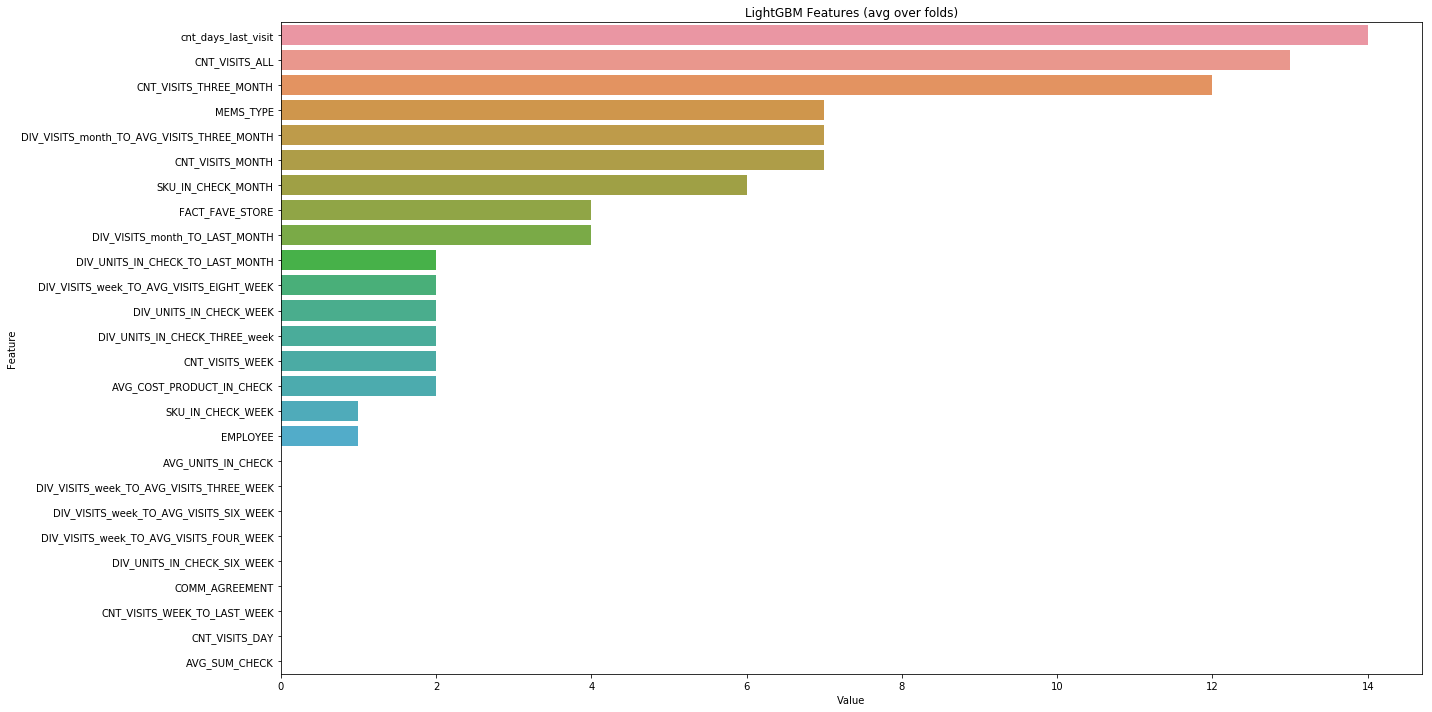

<Figure size 432x288 with 0 Axes>

In [33]:
feature_imp = pd.DataFrame(sorted(zip(gbm_1.feature_importances_,X_train_1.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')